## HW4: Train a deep convolution network with PyTorch for the CIFAR10 dataset

You should use:
(A) data augmentation 
(B) trained with ADAM
(C) dropout
(D) L2-regularization (Extra score*)


In [ ]:
#@title Student Information
#@markdown Enter the following info and run the cell:
Name = "Samin Heydarian" #@param {type:"string"}
StudentNumber =  99722058#@param {type:"integer"}

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


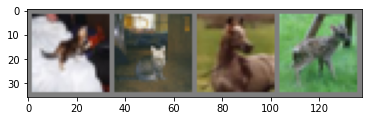

  cat   cat horse  deer


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# Define a Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):

        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

In [ ]:
weight_decays = [1e-4, 1e-3, 1e-2, 1e-1]

In [ ]:
for weight_decay in weight_decays:
  print('weight_decay: %s'% (weight_decay))

  net = CNN()
  if torch.cuda.is_available():
    net = net.cuda()


  # Define a Loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  if torch.cuda.is_available():
    criterion = criterion.cuda()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=weight_decay)

  print('Start Training')
  # Train the network
  for epoch in range(10):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
              running_loss = 0.0

  print('Finished Training')
  print('\n')


  PATH = './cifar_net.pth'
  torch.save(net.state_dict(), PATH)


  #net = Net()
  net.load_state_dict(torch.load(PATH))


  #test_accuracy
  correct = 0
  total = 0
  confusion_matrix = torch.zeros(len(classes), len(classes))
  with torch.no_grad():
      for data in testloader:
          images, labels = data

          if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()


          for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
  print('---------------------------------------------------------------')


  print('confusion_matrix:')
  print(confusion_matrix)
  print('---------------------------------------------------------------')


  #train_accuracy
  correct = 0
  total = 0
  confusion_matrix = torch.zeros(len(classes), len(classes))
  with torch.no_grad():
      for data in trainloader:
          images, labels = data

          if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()


          for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

  print('Accuracy of the network on the 50000 train images: %d %%' % (
      100 * correct / total))
  print('---------------------------------------------------------------')



  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  with torch.no_grad():
      for data in testloader:
          images, labels = data

          if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
          outputs = net(images)
          
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(4):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1


  for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
      

  print('#########################################################################################')
  print('\n\n\n')

weight_decay: 0.0001
Start Training
[1,  2000] loss: 1.756
[1,  4000] loss: 1.360
[1,  6000] loss: 1.151
[1,  8000] loss: 1.030
[1, 10000] loss: 0.970
[1, 12000] loss: 0.918
[2,  2000] loss: 0.808
[2,  4000] loss: 0.758
[2,  6000] loss: 0.742
[2,  8000] loss: 0.713
[2, 10000] loss: 0.699
[2, 12000] loss: 0.683
[3,  2000] loss: 0.561
[3,  4000] loss: 0.562
[3,  6000] loss: 0.568
[3,  8000] loss: 0.552
[3, 10000] loss: 0.561
[3, 12000] loss: 0.530
[4,  2000] loss: 0.421
[4,  4000] loss: 0.423
[4,  6000] loss: 0.431
[4,  8000] loss: 0.425
[4, 10000] loss: 0.442
[4, 12000] loss: 0.450
[5,  2000] loss: 0.318
[5,  4000] loss: 0.341
[5,  6000] loss: 0.337
[5,  8000] loss: 0.348
[5, 10000] loss: 0.345
[5, 12000] loss: 0.339
[6,  2000] loss: 0.233
[6,  4000] loss: 0.265
[6,  6000] loss: 0.265
[6,  8000] loss: 0.266
[6, 10000] loss: 0.284
[6, 12000] loss: 0.285
[7,  2000] loss: 0.177
[7,  4000] loss: 0.190
[7,  6000] loss: 0.209
[7,  8000] loss: 0.201
[7, 10000] loss: 0.230
[7, 12000] loss: 0.21

In [ ]:
classes = ('plane',
           'car',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')